In [ ]:
import kagglehub

# Download latest versiona
path = kagglehub.dataset_download("warcoder/infant-cry-audio-corpus")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/infant-cry-audio-corpus


In [ ]:
dataset_path = "/kaggle/input/infant-cry-audio-corpus/donateacry_corpus"

In [ ]:
import os

dataset_path = "/kaggle/input/infant-cry-audio-corpus/donateacry_corpus"
total_files = 0
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if not os.path.isdir(label_path):
        continue
    wav_files = [f for f in os.listdir(label_path) if f.endswith('.wav')]
    print(f"Label '{label}' has {len(wav_files)} files")
    total_files += len(wav_files)

print(f"Total audio files found: {total_files}")

Label 'hungry' has 382 files
Label 'burping' has 8 files
Label 'discomfort' has 27 files
Label 'belly_pain' has 16 files
Label 'tired' has 24 files
Total audio files found: 457


Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5174 - loss: 1.5266

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5137 - loss: 1.5367 - val_accuracy: 0.0580 - val_loss: 1.4274
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.2355 - loss: 1.6216 - val_accuracy: 0.0435 - val_loss: 1.5973
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2473 - loss: 1.4926

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2496 - loss: 1.4983 - val_accuracy: 0.8406 - val_loss: 1.1118
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3935 - loss: 1.5301

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3949 - loss: 1.5313 - val_accuracy: 0.8406 - val_loss: 0.9004
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4512 - loss: 1.3495

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.4478 - loss: 1.3549 - val_accuracy: 0.8406 - val_loss: 0.8940
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3878 - loss: 1.3875 - val_accuracy: 0.8116 - val_loss: 1.2575
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3496 - loss: 1.4088 - val_accuracy: 0.8406 - val_loss: 1.2393
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4391 - loss: 1.1195 - val_accuracy: 0.8261 - val_loss: 0.9668
Epoch 9/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.4664 - loss: 1.1438 - val_accuracy: 0.0725 - val_loss: 1.7541
Epoch 10/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4728 - loss: 1.0683 - val_accuracy: 0.8116 - val_loss: 1.0233
Epoch 11/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5129 - loss: 1.1296 - val_accuracy: 0.7971 - val_loss: 1.0473
Epoch 12/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5117 - loss: 0.8785 - val_accuracy: 0.7971 - val_loss:

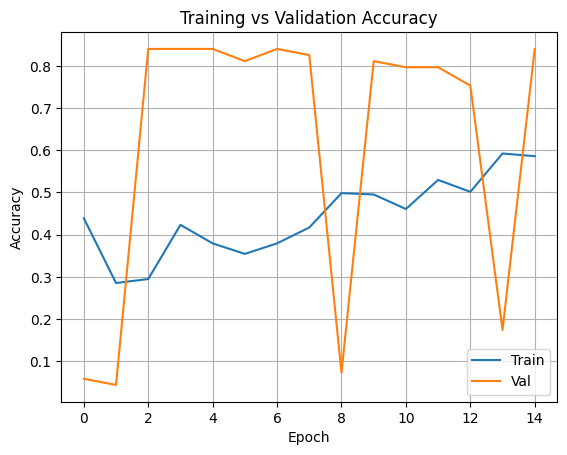

In [ ]:
# Infant Cry Classification - Full Training Script with Enhancements
import os
import random
import numpy as np
import librosa
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization,
                                     Reshape, Bidirectional, LSTM, Dense, GlobalAveragePooling1D,
                                     GlobalAveragePooling2D, Multiply, Lambda)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

# Settings
dataset_path = "/kaggle/input/infant-cry-audio-corpus/donateacry_corpus"
max_len = 216
n_mels = 128

def spec_augment(mel, freq_mask=10, time_mask=10):
    mel = mel.copy()
    f = random.randint(0, freq_mask)
    f0 = random.randint(0, mel.shape[0] - f)
    mel[f0:f0+f, :, :] = 0

    t = random.randint(0, time_mask)
    t0 = random.randint(0, mel.shape[1] - t)
    mel[:, t0:t0+t, :] = 0
    return mel

def extract_mel_features(file_path, max_len=216, augment=False):
    y, sr = librosa.load(file_path, sr=22050)
    if augment:
        if random.random() < 0.8:
            y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=random.choice([-2, -1, 1, 2]))
        if random.random() < 0.8:
            y = librosa.effects.time_stretch(y, rate=random.uniform(0.9, 1.1))
        if random.random() < 0.5:
            y += 0.005 * np.random.randn(len(y))
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    delta = librosa.feature.delta(mel_db)
    delta2 = librosa.feature.delta(mel_db, order=2)
    combined = np.stack([mel_db, delta, delta2], axis=-1)
    if combined.shape[1] < max_len:
        pad_width = max_len - combined.shape[1]
        combined = np.pad(combined, ((0, 0), (0, pad_width), (0, 0)), mode='constant')
    else:
        combined = combined[:, :max_len, :]
    if augment:
        combined = spec_augment(combined)
    return combined

def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Lambda(lambda x: tf.reshape(x, [-1, 1, 1, filters]))(se)
    return Multiply()([input_tensor, se])

def attention_block(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = Lambda(lambda x: tf.nn.softmax(x, axis=1))(attention)
    context_vector = Multiply()([attention, inputs])
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)
    return context_vector

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = attention_block(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])
    return model

# Load paths & labels
file_paths, labels = [], []
for label in os.listdir(dataset_path):
    for file in os.listdir(os.path.join(dataset_path, label)):
        if file.endswith(".wav"):
            file_paths.append(os.path.join(dataset_path, label, file))
            labels.append(label)
file_paths = np.array(file_paths)
labels = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
joblib.dump(le, "label_encoder.pkl")

# Train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(file_paths, y_encoded, test_size=0.15, stratify=y_encoded, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# Feature extraction
X_train = np.array([extract_mel_features(f, augment=True) for f in X_train])
X_val = np.array([extract_mel_features(f, augment=False) for f in X_val])
X_test = np.array([extract_mel_features(f, augment=False) for f in X_test])

# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_val_cat = tf.keras.utils.to_categorical(y_val)
y_test_cat = tf.keras.utils.to_categorical(y_test)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Build and train model
model = build_model((n_mels, max_len, 3), num_classes=len(le.classes_))
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("infant_cry_model.h5", save_best_only=True)
]
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=60,
    batch_size=16,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid()
plt.legend()
plt.show()


In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import joblib

# Parameters
dataset_path = "/kaggle/input/infant-cry-audio-corpus/donateacry_corpus"
max_len = 216
n_mels = 128

# Feature extraction
def extract_mel(file_path, max_len=216):
    y, sr = librosa.load(file_path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]
    return mel_db

# Load dataset
X, y = [], []
for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    for file in os.listdir(class_dir):
        if file.endswith(".wav"):
            path = os.path.join(class_dir, file)
            try:
                features = extract_mel(path, max_len)
                X.append(features)
                y.append(label)
            except Exception as e:
                print(f"Failed to process {file}: {e}")

X = np.array(X)
X = np.expand_dims(X, axis=-1)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, "label_encoder.pkl")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Model architecture: CNN + LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Dropout, Flatten, BatchNormalization, Reshape

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, max_len, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

model.save("infant_cry_model.h5")


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 512ms/step - accuracy: 0.2850 - loss: 44.9373 - val_accuracy: 0.7283 - val_loss: 33.9669
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1750 - loss: 19.5127 - val_accuracy: 0.0652 - val_loss: 35.2277
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3578 - loss: 8.3575 - val_accuracy: 0.3043 - val_loss: 19.3070
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6865 - loss: 1.5405 - val_accuracy: 0.5109 - val_loss: 7.9788
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5154 - loss: 1.3241 - val_accuracy: 0.6739 - val_loss: 3.5989
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6649 - loss: 1.4293 - val_accuracy: 0.7283 - val_loss: 3.9292
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7172 - loss: 0.3964 - val_accuracy: 0.8043 - val_loss: 3.2179
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8174 - loss: 0.2753 - val_accuracy: 0.8043 - val_l

In [ ]:

import joblib

# Save model and label encoder
model.save("infant_cry_model.h5")
joblib.dump(le, "label_encoder.pkl")



['label_encoder.pkl']

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok librosa scikit-learn tensorflow


In [ ]:
!pip install streamlit pyngrok librosa scikit-learn tensorflow


In [ ]:
!pip install streamlit pyngrok librosa joblib


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import librosa
import tensorflow as tf
import joblib

model = tf.keras.models.load_model("infant_cry_model.h5")
label_encoder = joblib.load("label_encoder.pkl")
max_len = 216
n_mels = 128

def extract_mel(file_path, max_len=max_len):
    y, sr = librosa.load(file_path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]
    return mel_db

def predict(file_path):
    features = extract_mel(file_path)
    features = np.expand_dims(features, axis=-1)
    features = np.expand_dims(features, axis=0)
    pred = model.predict(features)
    class_index = np.argmax(pred)
    class_label = label_encoder.inverse_transform([class_index])[0]
    confidence = pred[0][class_index]
    return class_label, confidence

st.title("👶 Infant Cry Audio Classification")

uploaded_file = st.file_uploader("Upload a WAV file", type=["wav"])
if uploaded_file is not None:
    st.audio(uploaded_file, format="audio/wav")
    with open("temp.wav", "wb") as f:
        f.write(uploaded_file.read())
    label, confidence = predict("temp.wav")
    st.success(f"Predicted Cry Type: **{label}**")
    st.write(f"Confidence: {confidence:.2f}")


Writing app.py


In [ ]:
!pkill ngrok


In [ ]:
from pyngrok import ngrok
ngrok.kill()


In [ ]:
!streamlit run app.py &>/content/log.txt &


In [ ]:
from pyngrok import ngrok

# ✅ Set your valid authtoken
ngrok.set_auth_token("2zM7vEN8WeLagjuGRGbLGt3Cmu1_5ZxSc3Q26bfwKN9Nn4BG5")

# ✅ Start the tunnel to port 8501 (Streamlit default)
public_url = ngrok.connect(8501)

print("🔗 Streamlit URL:", public_url)


🔗 Streamlit URL: NgrokTunnel: "https://ca73-34-16-244-228.ngrok-free.app" -> "http://localhost:8501"
